In [1]:
from src._modules import distance
from src._modules import sort
import os
import time
import json
import matplotlib.pyplot as plt

In [3]:
read_path = os.path.join("../src", 'rawData/query.json')
textfile = open(read_path, "r")
query = json.loads(textfile.read())
textfile.close()

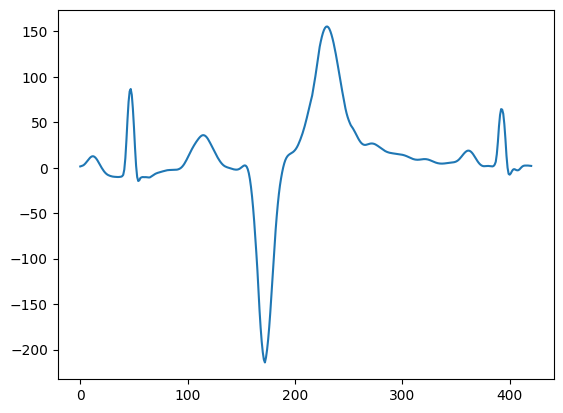

In [4]:
plt.plot(query)

In [5]:
# Normalize query
queryMean = sum(query) / len(query)
queryStd = 0
for i in range(0, len(query)):
    queryStd = queryStd + query[i]*query[i]
queryStd = (queryStd/len(query) - queryMean*queryMean) ** 0.5

normQuery = []
cumLB = []  # cumulative lower bound, which is not used in raw DTW
for i in range(0, len(query)):
    normQuery.append((query[i] - queryMean) / queryStd)
    cumLB.append(0)


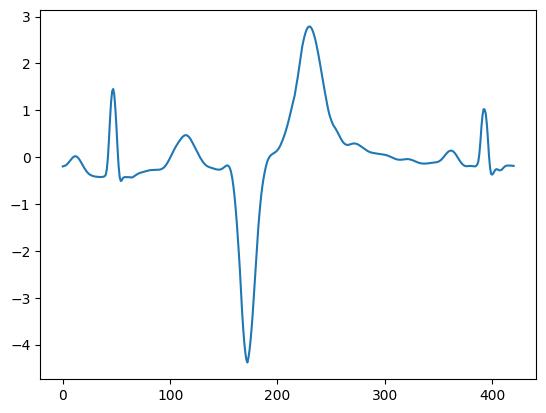

In [8]:
plt.plot(normQuery)

In [10]:
bsf = float("inf")
k = 5
scBand = 5
countKim = 0
countKeogh = 0
print('query mean   =', queryMean)
print('query std    =', queryStd)
print('query len    =', len(query))
print('best-so-far  =', bsf)
print('kNN neighbor =', k)
_, sortingOrder = sort.bubbleSort(normQuery)
print('Sakoe-Chiba  =', scBand)
print('ordering     =', sortingOrder)

query mean   = 11.561197862232783
query std    = 51.55687599477113
query len    = 421
best-so-far  = inf
kNN neighbor = 5
Sakoe-Chiba  = 5
ordering     = [172, 171, 173, 170, 174, 169, 175, 168, 176, 177, 167, 178, 166, 230, 229, 231, 228, 232, 227, 233, 226, 234, 179, 225, 235, 224, 236, 165, 223, 237, 180, 238, 222, 239, 164, 221, 240, 220, 181, 241, 219, 163, 242, 218, 182, 243, 47, 217, 244, 46, 162, 48, 216, 245, 183, 215, 45, 246, 214, 161, 247, 49, 213, 392, 393, 184, 248, 212, 394, 391, 249, 160, 211, 44, 250, 185, 210, 251, 395, 252, 209, 390, 253, 50, 159, 254, 186, 208, 255, 256, 54, 207, 55, 257, 115, 114, 158, 116, 113, 187, 56, 117, 112, 206, 258, 64, 63, 57, 65, 62, 60, 59, 61, 58, 35, 34, 53, 36, 33, 37, 32, 118, 111, 38, 31, 66, 30, 29, 39, 28, 67, 259, 396, 27, 110, 119, 68, 26, 40, 205, 400, 25, 69, 43, 109, 399, 260, 70, 24, 401, 120, 71, 157, 72, 188, 73, 389, 23, 108, 261, 74, 204, 75, 76, 121, 402, 77, 22, 262, 78, 271, 272, 107, 270, 79, 273, 269, 80, 274, 407, 

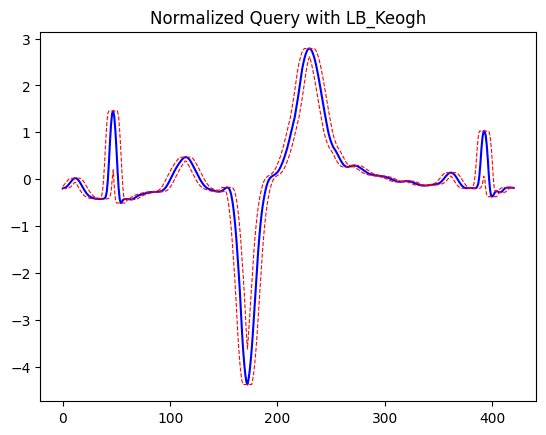

In [13]:
normQueryUp = []
normQueryLow = []
for i in range(0, scBand):
    normQueryUp.append(max(normQuery[0:i+scBand]))
    normQueryLow.append(min(normQuery[0:i+scBand]))
for i in range(scBand, len(query)-scBand):
    normQueryUp.append(max(normQuery[i-scBand+1:i+scBand]))
    normQueryLow.append(min(normQuery[i-scBand+1:i+scBand]))
for i in range(len(query)-scBand, len(query)):
    normQueryUp.append(max(normQuery[i-scBand+1:len(query)]))
    normQueryLow.append(min(normQuery[i-scBand+1:len(query)]))

plt.plot(normQuery, color='blue')
plt.plot(normQueryUp, color='red', linestyle='dashed', linewidth=0.8)
plt.plot(normQueryLow, color='red', linestyle='dashed', linewidth=0.8)
plt.title('Normalized Query with LB_Keogh')
plt.show()

In [14]:
read_path = os.path.join("../src", 'rawData/data.json')
textfile = open(read_path, "r")
data = json.loads(textfile.read())
textfile.close()

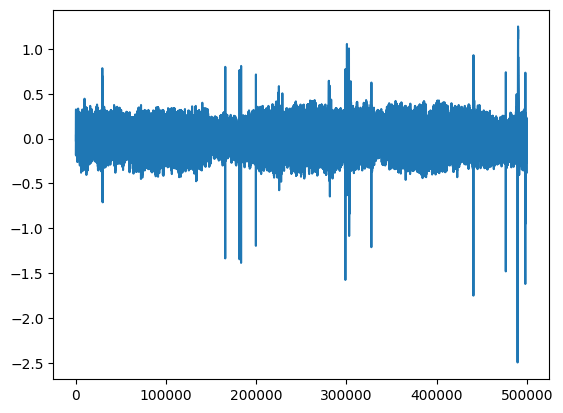

In [15]:
plt.plot(data)

In [16]:
match = []

# First k subsequence are assume to be nearest neigbour.

# Prepare sum of x and sum of x^2 for fast mean and std calculation.
# 1st subsequence : Full computation
subseq = data[0:len(query)]
subSeqSum = 0
subSeqSum2 = 0
for i in range(0, len(query)):
    subSeqSum = subSeqSum + data[i]
    subSeqSum2 = subSeqSum2 + data[i]*data[i]
subseqMean = subSeqSum / len(query)
subseqStd = (subSeqSum2 / len(query) - subseqMean * subseqMean) ** 0.5
q = list(normQuery)
s = list(subseq)
dist = distance.dynamicTimeWraping(
    q, s, subseqMean, subseqStd, cumLB, scBand, bsf)
match.append([dist, i])

In [17]:
# 2nd to len(query) subsequence : Online update
for i in range(1, k):
    old = subseq.pop(0)
    new = data[i+len(query)]
    subseq.append(new)
    subSeqSum = subSeqSum - old + new
    subSeqSum2 = subSeqSum2 - old*old + new*new
    subseqMean = subSeqSum / len(query)
    subseqStd = (subSeqSum2 / len(query) - subseqMean * subseqMean) ** 0.5
    q = list(normQuery)
    s = list(subseq)
    dist = distance.dynamicTimeWraping(
        q, s, subseqMean, subseqStd, cumLB, scBand, bsf)
    match.append([dist, i])

match.sort()

In [18]:
sf = match[k-1][0]

for i in range(k, len(data)-len(query)):
    old = subseq.pop(0)
    new = data[i+len(query)]
    subseq.append(new)
    subSeqSum = subSeqSum - old + new
    subSeqSum2 = subSeqSum2 - old*old + new*new
    subseqMean = subSeqSum / len(query)
    subseqStd = (subSeqSum2 / len(query) - subseqMean * subseqMean) ** 0.5

    # Start using lower bound
    dist, cumLB = distance.LB_Kim(
        normQuery, subseq, subseqMean, subseqStd, cumLB, bsf)
    if (dist < float('inf')):
        countKim = countKim + 1
        dist, cumLB = distance.LB_Keogh(
            normQueryUp, normQueryLow, subseq, subseqMean, subseqStd, sortingOrder, cumLB, bsf)
        if (dist < float('inf')):
            countKeogh = countKeogh + 1
            q = list(normQuery)
            s = list(subseq)
            dist = distance.dynamicTimeWraping(
                q, s, subseqMean, subseqStd, cumLB, scBand, bsf)
            if (dist < float('inf')):
                replaced = match.pop()
                match.append([dist, i])
                match.sort()
                bsf = match[k-1][0]
                # print('Replacing #', replaced[1], ' by #', i)

In [19]:
print('......', time.ctime(), ' finish running UCR_DTW ......')
passingRateKim = round(countKim/len(data) * 100, 4)
passingRateKeogh = round(countKeogh/len(data) * 100, 4)
print(f'Passing LB_Kim   : {passingRateKim} %',)
print(f'Passing LB_Keogh : {passingRateKeogh} %',)
print('kNN: ')
print(match)

...... Wed Feb  7 22:59:22 2024  finish running UCR_DTW ......
Passing LB_Kim   : 92.3608 %
Passing LB_Keogh : 0.6328 %
kNN: 
[[11.826377041081615, 165430], [12.093913926133004, 165428], [14.487153083812235, 165429], [15.299028878547224, 165431], [16.68265650433462, 165432]]


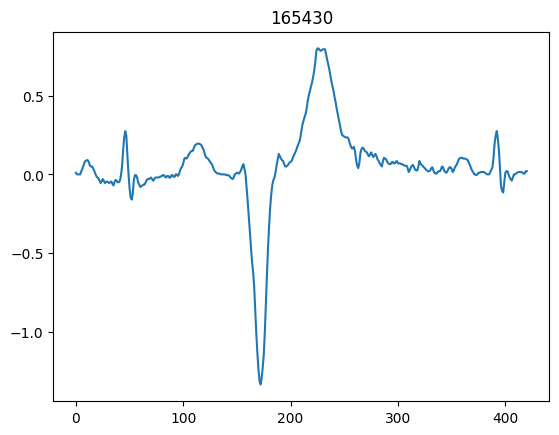

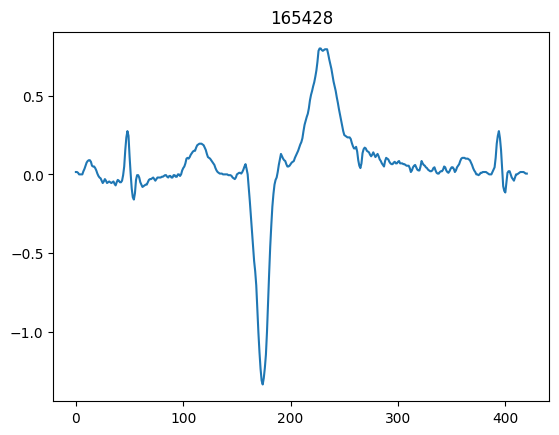

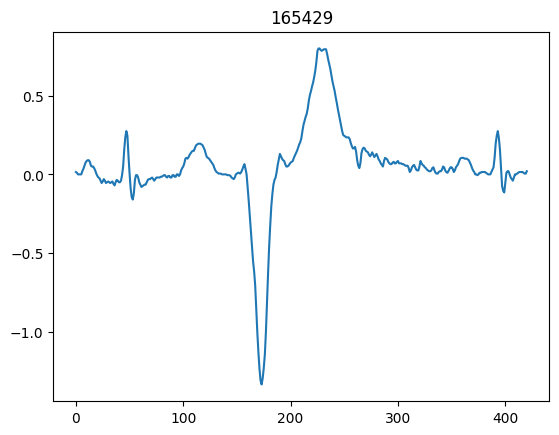

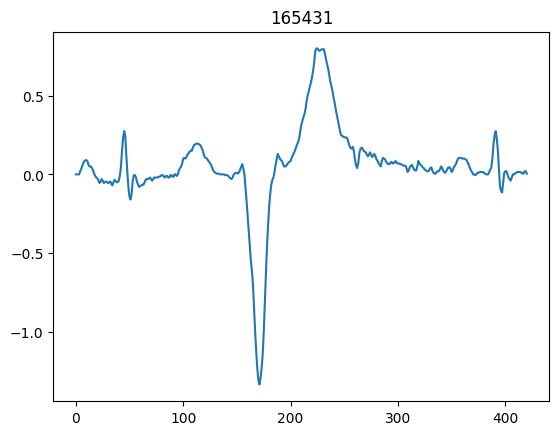

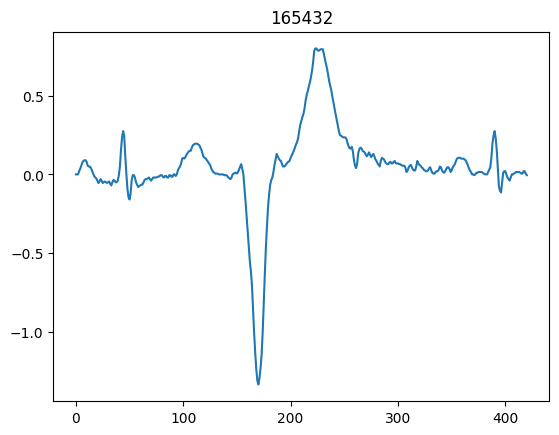

In [20]:
for i in range(0, k):
    plt.plot(data[match[i][1]:match[i][1]+len(query)])
    plt.title(match[i][1])
    plt.show()